In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import networkx as nx
import logging, sys
import cstrees.scoring as sc
import cstrees.cstree as ct
import cstrees.learning as ctl
import random
import causaldag
import matplotlib.pyplot as plt

#logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)
# CStree from Figure 1 in (Duarte & Solus, 2022)

/home/f/l/flrios/NOBACKUP/flrios/miniconda3/envs/cstrees/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


   0  1  2  3
0  2  2  2  2
1  1  1  1  1
2  1  1  1  0
3  1  1  0  1
4  1  1  0  1
5  0  1  0  1


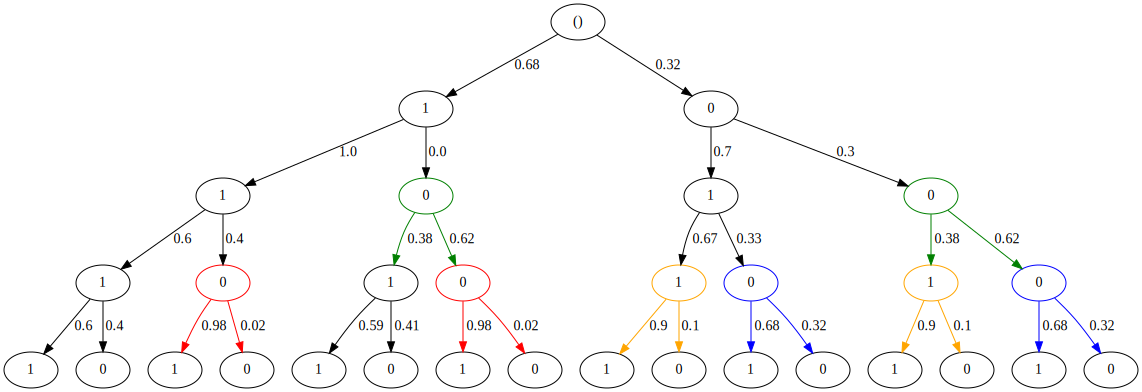

In [20]:
np.random.seed(1)
random.seed(2)
p=4
cards = [2] * p

tree = ct.CStree(cards) # Maybe an optional label here. defaults to range(p)

# These do not have to be in a dict like this as the levels are
# determined from the length of the tuples.

# This has singletons so its not allowed in set_tree_probs!
tree.update_stages({
    0: [ct.Stage([0], color="black"), ct.Stage([1], color="black")],
    1: [ct.Stage([{0, 1}, 0], color="green"), ct.Stage([0, 1], color="black"), ct.Stage([1, 1], color="black")] ,    # Green
    2: [ct.Stage([0, {0, 1}, 0], color="blue"),  # Blue
        ct.Stage([0, {0, 1}, 1], color="orange"),  # Orange
        ct.Stage([1, {0, 1}, 0], color="red"),  # Red
        ct.Stage([1, 1, 1], color="black"),
        ct.Stage([1, 0, 1], color="black")]  
})

tree.set_random_stage_parameters()

a = tree.plot()
a.draw("cstree.png")
x = tree.sample(5)

print(x)

s = sc.score(tree, x, alpha_tot=1.0, method="K2")

#rels = tree.csi_relations()

#print("Initial rels")
#print(rels)
adjmats = tree.to_minimal_context_graphs() # put labels here maybe

for key, graph in adjmats.items():
    agraph = nx.nx_agraph.to_agraph(graph)
    agraph.layout("dot")
    agraph.draw(str(key) + "_csi.png", args='-Glabel="'+str(key)+'"   ')
a

In [4]:
p=4
cards = [2] * p 

      0  1  2  3
0     2  2  2  2
1     1  0  0  0
2     1  1  1  1
3     1  0  0  0
4     1  0  0  0
...  .. .. .. ..
996   0  0  0  0
997   0  1  0  0
998   1  0  0  0
999   1  1  0  0
1000  1  1  0  1

[1001 rows x 4 columns]


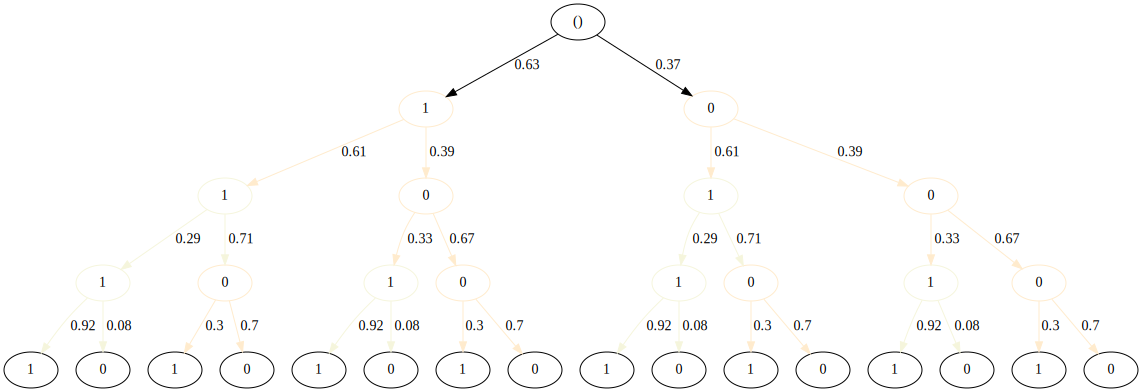

In [12]:
np.random.seed(5)

t = ct.sample_cstree([2,2,2,2], max_cvars=1, prob_cvar=0.5, prop_nonsingleton=1)
t.set_random_stage_parameters()

a = t.plot()
x = t.sample(1000)
print(x)
#plt.savefig("testplot.png")

true_cdags = t.to_minimal_context_graphs()
for key, val in true_cdags.items():
    agraph = nx.nx_agraph.to_agraph(val)
    agraph.layout("dot")
    agraph.draw("testing/"+str(key) + "_true.png", args='-Glabel="'+str(key)+'"   ')
a

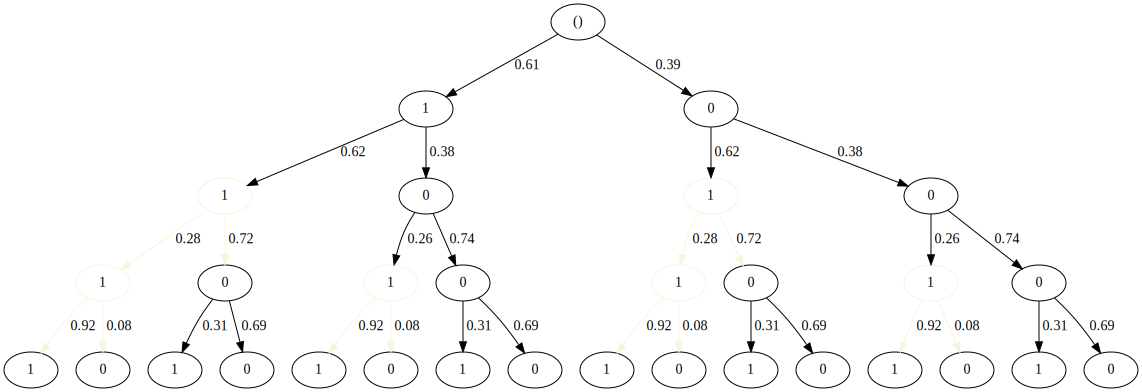

In [13]:
# Should we need to put order here? Or just the labels?
# Or nothing?
t.estimate_stage_parameters(x, alpha_tot=1.0, method="BDeu")
a = t.plot()
a

In [14]:
order = [0, 1, 2, 3]

perm = [1,0,2, 3]
xperm = x[perm]

# checking that thy give the same result. MAybe thisuis better checked on a CStree
# lvelel instead of the order.

s2 = sc.score_order(perm, xperm, max_cvars=1, alpha_tot=1.0, method="BDeu")
s1 = sc.score_order(order, x, max_cvars=1, alpha_tot=1.0, method="BDeu")

print(s1)
print(s2)

-2462.9625544713263
-2462.9625544713263


order: [0, 1, 2, 3], score: -2462.9625544713263
order: [0, 1, 3, 2], score: -2462.9625544713263
order: [0, 2, 1, 3], score: -2462.9625544713263
order: [0, 2, 3, 1], score: -2462.9625544713263
order: [0, 3, 1, 2], score: -2462.9625544713263
order: [0, 3, 2, 1], score: -2462.9625544713263
order: [1, 0, 2, 3], score: -2462.9625544713263
order: [1, 0, 3, 2], score: -2462.9625544713263
order: [1, 2, 0, 3], score: -2462.9625544713263
order: [1, 2, 3, 0], score: -2462.9625544713263
order: [1, 3, 0, 2], score: -2462.9625544713263
order: [1, 3, 2, 0], score: -2462.9625544713263
order: [2, 0, 1, 3], score: -2462.9625544713263
order: [2, 0, 3, 1], score: -2462.9625544713263
order: [2, 1, 0, 3], score: -2462.9625544713263
order: [2, 1, 3, 0], score: -2462.9625544713263
order: [2, 3, 0, 1], score: -2462.9625544713263
order: [2, 3, 1, 0], score: -2462.9625544713263
order: [3, 0, 1, 2], score: -2462.9625544713263
order: [3, 0, 2, 1], score: -2462.9625544713263
order: [3, 1, 0, 2], score: -2462.962554

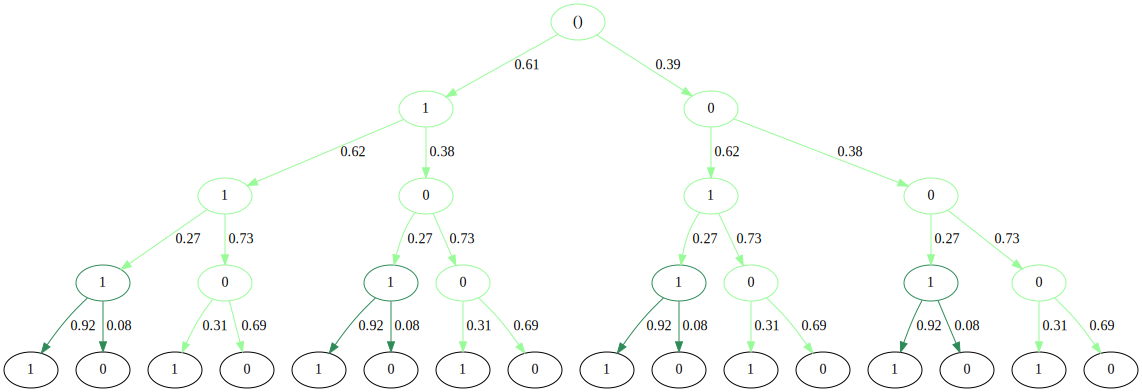

In [15]:
optord, score = ctl.find_optimal_order(x, strategy="max", max_cvars=1, alpha_tot=1.0, method="BDeu")
print("optimal order: {}, score {}".format(optord, score))

opttree = ctl.optimal_cstree(optord, x, max_cvars=1, alpha_tot=1.0, method="BDeu")
print("stages :{}".format(opttree.stages))
opttree.estimate_stage_parameters(x, alpha_tot=1.0, method="BDeu")
opttree.plot()

In [10]:
cdags = opttree.to_minimal_context_graphs()
for key, graph in cdags.items():
    print("key: {}".format(key))
    print(graph.edges())
    print(graph.nodes())
    cdag = causaldag.DAG(arcs=set(graph.edges()))
    cpdag = cdag.cpdag()
    print(cpdag.arcs)
    print(cpdag.edges)
    print(type(cpdag))
    

key: None
[(1, 3)]
[0, 1, 2, 3]
set()
{frozenset({1, 3})}
<class 'graphical_models.classes.dags.pdag.PDAG'>


max staging: ['[]']
max staging: ['[{0, 1}]']
max staging: ['[{0, 1}, {0, 1}]']
max staging: ['[{0, 1}, 0, {0, 1}]', '[{0, 1}, 1, {0, 1}]']


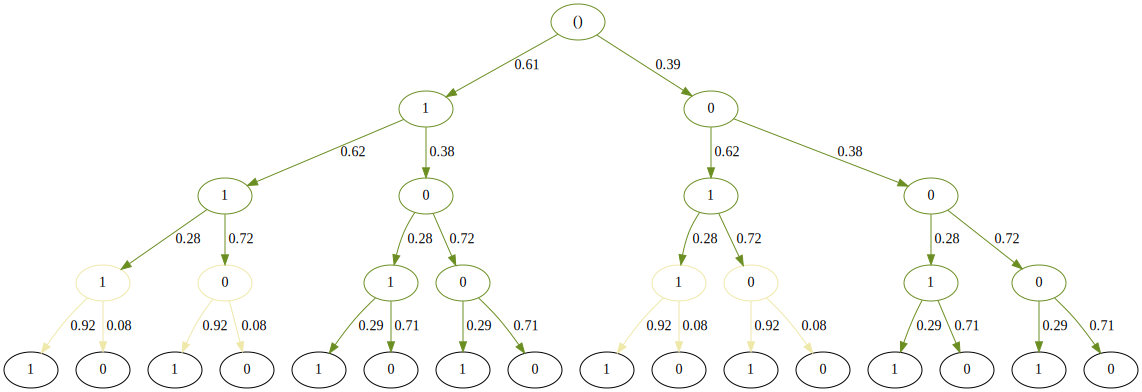

In [11]:
order = [0, 1, 2, 3]

opttree = ctl.optimal_cstree(order, x, max_cvars=1, alpha_tot=1.0, method="BDeu")
#print("stages :{}".format(opttree.stages))
opttree.estimate_stage_parameters(x, alpha_tot=1.0, method="BDeu")
opttree.plot()

In [12]:
optord = ctl.find_optimal_order(x, max_cvars=1, alpha_tot=1.0, method="BDeu")

order: [0, 1, 2, 3], score: -2353.780521799141
order: [0, 1, 3, 2], score: -2353.780521799141
order: [0, 2, 1, 3], score: -2353.780521799141
order: [0, 2, 3, 1], score: -2353.780521799141
order: [0, 3, 1, 2], score: -2353.780521799141
order: [0, 3, 2, 1], score: -2353.780521799141
order: [1, 0, 2, 3], score: -2353.780521799141
order: [1, 0, 3, 2], score: -2353.780521799141
order: [1, 2, 0, 3], score: -2353.780521799141
order: [1, 2, 3, 0], score: -2353.780521799141
order: [1, 3, 0, 2], score: -2353.780521799141
order: [1, 3, 2, 0], score: -2353.780521799141
order: [2, 0, 1, 3], score: -2353.780521799141
order: [2, 0, 3, 1], score: -2353.780521799141
order: [2, 1, 0, 3], score: -2353.780521799141
order: [2, 1, 3, 0], score: -2353.780521799141
order: [2, 3, 0, 1], score: -2353.780521799141
order: [2, 3, 1, 0], score: -2353.780521799141
order: [3, 0, 1, 2], score: -2353.780521799141
order: [3, 0, 2, 1], score: -2353.780521799141
order: [3, 1, 0, 2], score: -2353.780521799141
order: [3, 1,

In [17]:

order = [0, 1, 2, 3]
score = sc.score_order(order, x, max_cvars=1, alpha_tot=1.0, method="BDeu")
print(score)
 

-2353.780521799141


In [44]:
cards = 5*[2]
p = len(cards)

In [45]:
stagings = ctl.all_stagings(p, cards, 4, max_cvars=1)
print("#Stagings")
nst = ctl.n_stagings(p, cards, 4, max_cvars=1)
print(nst)
print("Stagings")
for ss in stagings:
    for s in ss:
        print(s)

#Stagings
['[0, {0, 1}, {0, 1}, {0, 1}, {0, 1}]', '[1, {0, 1}, {0, 1}, {0, 1}, {0, 1}]']
['[{0, 1}, 0, {0, 1}, {0, 1}, {0, 1}]', '[{0, 1}, 1, {0, 1}, {0, 1}, {0, 1}]']
['[{0, 1}, {0, 1}, 0, {0, 1}, {0, 1}]', '[{0, 1}, {0, 1}, 1, {0, 1}, {0, 1}]']
['[{0, 1}, {0, 1}, {0, 1}, 0, {0, 1}]', '[{0, 1}, {0, 1}, {0, 1}, 1, {0, 1}]']
['[{0, 1}, {0, 1}, {0, 1}, {0, 1}, 0]', '[{0, 1}, {0, 1}, {0, 1}, {0, 1}, 1]']
['[{0, 1}, {0, 1}, {0, 1}, {0, 1}, {0, 1}]']
0
Stagings
[0, {0, 1}, {0, 1}, {0, 1}, {0, 1}]
[1, {0, 1}, {0, 1}, {0, 1}, {0, 1}]
[{0, 1}, 0, {0, 1}, {0, 1}, {0, 1}]
[{0, 1}, 1, {0, 1}, {0, 1}, {0, 1}]
[{0, 1}, {0, 1}, 0, {0, 1}, {0, 1}]
[{0, 1}, {0, 1}, 1, {0, 1}, {0, 1}]
[{0, 1}, {0, 1}, {0, 1}, 0, {0, 1}]
[{0, 1}, {0, 1}, {0, 1}, 1, {0, 1}]
[{0, 1}, {0, 1}, {0, 1}, {0, 1}, 0]
[{0, 1}, {0, 1}, {0, 1}, {0, 1}, 1]
[{0, 1}, {0, 1}, {0, 1}, {0, 1}, {0, 1}]


In [ ]:
for l in range(len(order)):
    max_staging, max_score = ct.optimal_staging_at_level(order, cards, x, l, max_cvars=1, alpha_tot=1.0, method="BDeu")
    print("best staging at level {}".format(l))
    print(max_score)   
    for st in max_staging:
        print(st)

    